# Using Foursquare to predict land prices in São Paulo

_Capstone project for the IBM Professional Data Science Certification program_

In this project we use Foursquare venue locations associated with publicly available land value data to create a model to predict land prices using Regression algorithms.

## Introduction

It is known that close-by amenities can have an impact on land prices. This project intends to cross information already known from land prices in the city of São Paulo with Foursquare venue locations, in order to create a model capable of predicting land prices for a given location in the city.

The following objectives will be pursued by this work:
- Extract statistics and create land price visualizations from public available data on land value;
- Create a simple regression model to predict land prices based on this public data;
- Improve this model by adding venue locations extracted from the Foursquare API;
- Measure and compare the efficiency of each model.

The main beneficiaries from this report will be real estate investors and agents followed by anyone searching for a good place to live in the city. Also, it adds value to the Data Science community as a whole as the result of the conducted research will contribute to evaluate if the use of Foursquare data can benefit other land price prediction models.

## Data

To perform this research, two main datasets will be used:

### [Public data from São Paulo's city hall related with land value in the city](http://dados.prefeitura.sp.gov.br/dataset/base-de-dados-do-imposto-predial-e-territorial-urbano-iptu)
The city Hall of São Paulo has made available data regarding to the land taxes paid in the city. In this data there's also interesting data about the land value by m2 for different neighbourhoods in the city. 

The table below is an example of this data, where columns "BAIRRO DO IMOVEL" and "VALOR DO M2 DO TERRENO" show neighbourhood and the land value by m2, respectively.

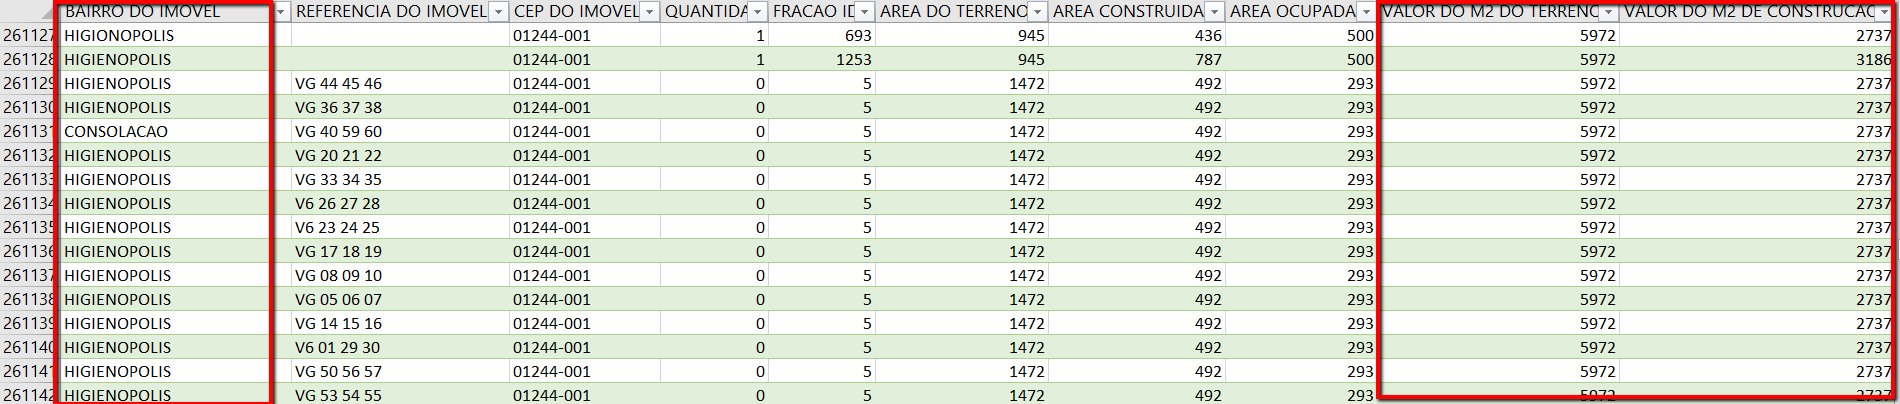


### [Foursquare API](https://developer.foursquare.com/docs) to retrieve venue locations
 
Foursquare holds the location for venues in different categories (bars, cinemas, supermarkets, museums, etc). 

### Import required libraries

In [1]:
!conda install -c conda-forge folium=0.10.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.10.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    folium-0.10.0              |             py_0          59 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be

In [2]:
!conda install fiona pyproj six
!pip install geopandas
!conda upgrade --all

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - fiona
    - pyproj
    - six


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libgdal-2.3.3              |       h2e7e64b_0        17.7 MB
    certifi-2019.6.16          |           py36_1         156 KB
    fiona-1.8.4                |   py36hc38cc03_0         1.0 MB
    poppler-data-0.4.9         |                0         3.5 MB
    giflib-5.1.4               |       h14c3975_1          78 KB
    hdf4-4.2.13                |       h3ca952b_2         916 KB
    poppler-0.65.0             |       h581218d_1         1.6 MB
    kealib-1.4.7               |       hd0c454d_6         175 KB
    libkml-1.3.0               |       h590aaf7_4         633 KB
    libspatialite-4.3.0a       |      hb08deb6_19         3.1 MB
    openjpeg-2.3.0             |       h05c96f

In [3]:
#!conda remove matplotlib
!pip install matplotlib==3.0.2

     |████████████████████████████████| 12.9MB 1.1MB/s eta 0:00:01
  Found existing installation: matplotlib 3.1.0
    Uninstalling matplotlib-3.1.0:
      Successfully uninstalled matplotlib-3.1.0


In [32]:
#!conda install seaborn

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following NEW packages will be INSTALLED:

    matplotlib: 3.1.0-py36h5429711_0
    seaborn:    0.9.0-py36_0        

Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [4]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from pandas.plotting import scatter_matrix
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import folium
import types
import os
import io
import json
import requests
from urllib.request import urlopen
import urllib.parse
from botocore.client import Config
import ibm_boto3

### Import land value data

Import the data obtained from São Paulo's City Hall website. 

In [5]:
def loadLandValueData():
    dfs = []
    for i in range(1, 5):
      filename = 'iptu_part' + str(i) + '.csv'
      url="https://github.com/guilhermelemmi/landvalue-sp/raw/master/data/" + filename
      #s=requests.get(url).content#
      c=pd.read_csv(url, encoding='iso-8859-1')
      dfs.append(c)
    return pd.concat(dfs, sort=True)

In [6]:
landvalueDF = loadLandValueData()
landvalueDF.shape

(3219739, 19)

### Data wrangling and cleanup

Discard some columns that will not be relevant and translate the remaining columns:

In [7]:
landvalueDF.drop(columns=[   
    'CEP DO IMOVEL',
    'COMPLEMENTO DO IMOVEL',
    'NOME DE LOGRADOURO DO IMOVEL',
    'NUMERO DO IMOVEL',
    'REFERENCIA DO IMOVEL'
], inplace=True)

In [8]:
landvalueDF.rename(columns={
    'ANO DA CONSTRUCAO CORRIGIDO':'CONSTRUCTION YEAR',
    'AREA CONSTRUIDA':'CONSTRUCTED AREA',
    'AREA DO TERRENO':'TOTAL AREA',
    'AREA OCUPADA':'SOIL OCCUPATION',
    'BAIRRO DO IMOVEL':'NEIGHBOURHOOD',
    'FATOR DE OBSOLESCENCIA':'OBSOLESCENCE FACTOR',
    'FRACAO IDEAL':'IDEAL FRACTION',
    'QUANTIDADE DE ESQUINAS/FRENTES':'NUMBER OF FACADES',
    'QUANTIDADE DE PAVIMENTOS':'NUMBER OF FLOORS',
    'TIPO DE PADRAO DA CONSTRUCAO':'CONSTRUCTION TYPE',
    'TIPO DE TERRENO':'LAND POSITION',
    'TIPO DE USO DO IMOVEL':'TYPE',    
    'VALOR DO M2 DE CONSTRUCAO':'CONSTRUCTED M2 PRICE',
    'VALOR DO M2 DO TERRENO':'BARE M2 PRICE'
}, inplace=True)

Keep only records belonging to districts that are known:

In [9]:
districts = ["BELA VISTA","LIBERDADE","PARI","MOOCA","VILA ANDRADE","CAMBUCI","ITAIM BIBI","CONSOLACAO","PINHEIROS","VILA LEOPOLDINA","CAMPO LIMPO","MORUMBI","IPIRANGA","RAPOSO TAVARES","JARDIM PAULISTA","RIO PEQUENO","ALTO DE PINHEIROS","CURSINO","REPUBLICA","JABAQUARA","BELEM","CIDADE ADEMAR","CAMPO BELO","VILA MARIANA","VILA PRUDENTE","VILA GUILHERME","SANTANA","PERDIZES","VILA FORMOSA","SANTO AMARO","LAPA","SE","ERMELINO MATARAZZO","CASA VERDE","ANHANGUERA","VILA MEDEIROS","VILA MARIA","PERUS","BARRA FUNDA","MANDAQUI","ARICANDUVA","TUCURUVI","PENHA","SAPOPEMBA","PIRITUBA","CACHOEIRINHA","MOEMA","PARQUE DO CARMO","IGUATEMI","VILA MATILDE","ARTUR ALVIM","ITAQUERA","PONTE RASA","VILA JACUI","JAGUARA","LAJEADO","GUAIANASES","CIDADE TIRADENTES","ITAIM PAULISTA","CARRAO","JARDIM HELENA","PARELHEIROS","MARSILAC","SOCORRO","PEDREIRA","CIDADE DUTRA","CAMPO GRANDE","BOM RETIRO","VILA SONIA","JAGUARE","JARDIM SAO LUIS","JARDIM ANGELA","AGUA RASA","CAPAO REDONDO","LIMAO","SACOMA","SAUDE","SANTA CECILIA","TATUAPE","SAO LUCAS","BUTANTA","SAO DOMINGOS","JARAGUA","BRAS","FREGUESIA DO O","BRASILANDIA","TREMEMBE","JACANA","CANGAIBA","CIDADE LIDER","SAO MATEUS","SAO RAFAEL","JOSE BONIFACIO","SAO MIGUEL","GRAJAU","VILA CURUCA"]
landvalueDF = landvalueDF[landvalueDF['NEIGHBOURHOOD'].isin(districts)]
landvalueDF.head()

,CONSTRUCTION YEAR,CONSTRUCTED AREA,TOTAL AREA,SOIL OCCUPATION,NEIGHBOURHOOD,OBSOLESCENCE FACTOR,IDEAL FRACTION,NUMBER OF FACADES,NUMBER OF FLOORS,CONSTRUCTION TYPE,LAND POSITION,TYPE,CONSTRUCTED M2 PRICE,BARE M2 PRICE
5,1954,1804,310,285,BOM RETIRO,2,1,0,8,Residencial vertical - padrão C,Normal,"Prédio de apartamento, não em condomínio, de u...",1894,1984
170,1924,100,116,92,BOM RETIRO,2,1,0,1,Residencial horizontal - padrão C,Normal,Residência,1554,961
296,1970,280,148,140,SANTANA,46,1,2,2,Comercial horizontal - padrão B,De duas ou mais frentes,Loja,1478,972
344,1970,300,200,150,BARRA FUNDA,46,1,0,2,Comercial horizontal - padrão B,Normal,Loja e residência (predominância comercial),1478,938
411,1961,175,300,155,BOM RETIRO,3,13,0,7,Comercial vertical - padrão B,Normal,Loja em edifício em condomínio (unidade autônoma),1894,927


Merge the two M2 Price columns into a single column with their mean value:

In [10]:
landvalueDF['M2 PRICE'] = (landvalueDF['CONSTRUCTED M2 PRICE'] + landvalueDF['BARE M2 PRICE']) / 2
landvalueDF.drop(columns=[
    'CONSTRUCTED M2 PRICE',
    'BARE M2 PRICE'
], inplace=True)
landvalueDF.head()

,CONSTRUCTION YEAR,CONSTRUCTED AREA,TOTAL AREA,SOIL OCCUPATION,NEIGHBOURHOOD,OBSOLESCENCE FACTOR,IDEAL FRACTION,NUMBER OF FACADES,NUMBER OF FLOORS,CONSTRUCTION TYPE,LAND POSITION,TYPE,M2 PRICE
5,1954,1804,310,285,BOM RETIRO,2,1,0,8,Residencial vertical - padrão C,Normal,"Prédio de apartamento, não em condomínio, de u...",1939.0
170,1924,100,116,92,BOM RETIRO,2,1,0,1,Residencial horizontal - padrão C,Normal,Residência,1257.5
296,1970,280,148,140,SANTANA,46,1,2,2,Comercial horizontal - padrão B,De duas ou mais frentes,Loja,1225.0
344,1970,300,200,150,BARRA FUNDA,46,1,0,2,Comercial horizontal - padrão B,Normal,Loja e residência (predominância comercial),1208.0
411,1961,175,300,155,BOM RETIRO,3,13,0,7,Comercial vertical - padrão B,Normal,Loja em edifício em condomínio (unidade autônoma),1410.5


Check data types:

In [11]:
landvalueDF.dtypes

CONSTRUCTION YEAR        int64
CONSTRUCTED AREA         int64
TOTAL AREA               int64
SOIL OCCUPATION          int64
NEIGHBOURHOOD           object
OBSOLESCENCE FACTOR      int64
IDEAL FRACTION           int64
NUMBER OF FACADES        int64
NUMBER OF FLOORS         int64
CONSTRUCTION TYPE       object
LAND POSITION           object
TYPE                    object
M2 PRICE               float64
dtype: object

Check value distribution searching for possible M2 PRICE bins:

In [12]:
landvalueDF['M2 PRICE'].astype(str).value_counts()

1802.0    2400
581.0     1254
2128.5    1146
742.0     1056
1154.0    1047
          ... 
4075.5       1
2612.5       1
3562.5       1
5123.0       1
3987.5       1
Name: M2 PRICE, Length: 8283, dtype: int64

There are many different price values, enough for us to deal with it as a continuous value.

Let's check the most expensive M2 Prices in the data:

In [13]:
landvalueDF.sort_values(by ='M2 PRICE', ascending=False).head(10)

,CONSTRUCTION YEAR,CONSTRUCTED AREA,TOTAL AREA,SOIL OCCUPATION,NEIGHBOURHOOD,OBSOLESCENCE FACTOR,IDEAL FRACTION,NUMBER OF FACADES,NUMBER OF FLOORS,CONSTRUCTION TYPE,LAND POSITION,TYPE,M2 PRICE
165166,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165169,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165168,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165171,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165172,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165167,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165145,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165148,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165149,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0
165150,2002,472,2088,1749,BELA VISTA,88,245,1,19,Comercial vertical - padrão E,De esquina,Escritório/consultório em condomínio (unidade ...,14137.0


Remove some gross outliers from data:

In [14]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-3*iqr
    fence_high = q3+3*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


landvalueDF = remove_outlier(landvalueDF, 'M2 PRICE')
landvalueDF = remove_outlier(landvalueDF, 'CONSTRUCTED AREA')
landvalueDF = remove_outlier(landvalueDF, 'CONSTRUCTION YEAR')
landvalueDF = remove_outlier(landvalueDF, 'IDEAL FRACTION')
landvalueDF = remove_outlier(landvalueDF, 'SOIL OCCUPATION')
landvalueDF = remove_outlier(landvalueDF, 'TOTAL AREA')

### Import GeoJSON data

Load Sao Paulo's districts GEOJSON.

In [15]:
urlGeoJson = 'https://raw.githubusercontent.com/guilhermelemmi/landvalue-sp/master/data/distritos_sp.json'
geojsonFile = urlopen(urlGeoJson)
geojson = json.loads(geojsonFile.read())

### Get Districts Centroid Coordinates

In [49]:
with open('districts.geojson', "w") as file:
    file.write(json.dumps(geojson))
zones = gpd.read_file('districts.geojson')

for i in range(0,len(geojson['features'])):
    zones.loc[i,'centroid_lon'] = zones.geometry.centroid.x.iloc[i]
    zones.loc[i,'centroid_lat'] = zones.geometry.centroid.y.iloc[i]
zones

,cartodb_id,id,mun_sigla,mun_nome,cod_ibge,sigla,nome,nomecaps,incidencia,geometry,centroid_lon,centroid_lat
0,34,22,SAO,SAO PAULO,355030807,BVI,Bela Vista,BELA VISTA,8.5,"(POLYGON ((-46.648614 -23.567189, -46.653394 -...",-46.647027,-23.560400
1,38,24,SAO,SAO PAULO,355030849,LIB,Liberdade,LIBERDADE,7.1,"(POLYGON ((-46.640735 -23.572888, -46.640488 -...",-46.631528,-23.566521
2,42,259,SAO,SAO PAULO,355030856,PRI,Pari,PARI,16.4,"(POLYGON ((-46.624928 -23.519002, -46.623455 -...",-46.617179,-23.526806
3,21,30,SAO,SAO PAULO,355030853,MOO,Mooca,MOOCA,5.1,"(POLYGON ((-46.603601 -23.566726, -46.604565 -...",-46.596134,-23.560910
4,8,3,SAO,SAO PAULO,355030883,VAN,Vila Andrade,VILA ANDRADE,2.2,"(POLYGON ((-46.727635 -23.61106, -46.721546 -2...",-46.728013,-23.625839
5,19,29,SAO,SAO PAULO,355030814,CMB,Cambuci,CAMBUCI,5.2,"(POLYGON ((-46.617807 -23.578618, -46.618909 -...",-46.616623,-23.563925
6,29,9,SAO,SAO PAULO,355030835,IBI,Itaim Bibi,ITAIM BIBI,9.5,"(POLYGON ((-46.70093 -23.61956, -46.700576 -23...",-46.685138,-23.601715
7,66,66,SAO,SAO PAULO,355030826,CON,Consolação,CONSOLACAO,1.7,"(POLYGON ((-46.65861 -23.558781, -46.662576 -2...",-46.659763,-23.548199
8,32,12,SAO,SAO PAULO,355030862,PIN,Pinheiros,PINHEIROS,4.6,"(POLYGON ((-46.676969 -23.550733, -46.678303 -...",-46.688358,-23.565979
9,6,116,SAO,SAO PAULO,355030888,VLE,Vila Leopoldina,VILA LEOPOLDINA,9.7,"(POLYGON ((-46.73427 -23.545335, -46.746965 -2...",-46.734131,-23.528787


### Load Venues close to each centroid

In [17]:
# The code was removed by Watson Studio for sharing.

'https://api.foursquare.com/v2/venues/explore?&client_id=MBLG0GXG1YLBHH2PW1JVEOEHF2EZEUOHAHFSTSEQPZWYVSLK&client_secret=QT4CBHY1WBX4PCG5TOPPRE1SFOGD3JKZC1PXDTSXWAK3FPJF&v=20190801&ll=-23.56040027667004,-46.64702724763833&radius=1000&limit=50'

In [34]:
LIMIT=50
radius = 1000
def get_venues_for_price(lat, lng, tier):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&price={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT,
        tier)
    return json_normalize(requests.get(url).json())

In [50]:
for i, zone in zones.iterrows():
    tier1 = get_venues_for_price(zones.loc[i]['centroid_lat'], zones.loc[i]['centroid_lon'], '1')
    tier2 = get_venues_for_price(zones.loc[i]['centroid_lat'], zones.loc[i]['centroid_lon'], '2')
    tier3 = get_venues_for_price(zones.loc[i]['centroid_lat'], zones.loc[i]['centroid_lon'], '3')
    tier4 = get_venues_for_price(zones.loc[i]['centroid_lat'], zones.loc[i]['centroid_lon'], '4')
    zones.loc[i, 'price_tier1_count'] = tier1.loc[0]['response.totalResults']
    zones.loc[i, 'price_tier2_count'] = tier2.loc[0]['response.totalResults']
    zones.loc[i, 'price_tier3_count'] = tier3.loc[0]['response.totalResults']
    zones.loc[i, 'price_tier4_count'] = tier4.loc[0]['response.totalResults']
zones

,cartodb_id,id,mun_sigla,mun_nome,cod_ibge,sigla,nome,nomecaps,incidencia,geometry,centroid_lon,centroid_lat,price_tier1_count,price_tier2_count,price_tier3_count,price_tier4_count
0,34,22,SAO,SAO PAULO,355030807,BVI,Bela Vista,BELA VISTA,8.5,"(POLYGON ((-46.648614 -23.567189, -46.653394 -...",-46.647027,-23.560400,28.0,63.0,22.0,1.0
1,38,24,SAO,SAO PAULO,355030849,LIB,Liberdade,LIBERDADE,7.1,"(POLYGON ((-46.640735 -23.572888, -46.640488 -...",-46.631528,-23.566521,25.0,28.0,6.0,0.0
2,42,259,SAO,SAO PAULO,355030856,PRI,Pari,PARI,16.4,"(POLYGON ((-46.624928 -23.519002, -46.623455 -...",-46.617179,-23.526806,27.0,34.0,4.0,1.0
3,21,30,SAO,SAO PAULO,355030853,MOO,Mooca,MOOCA,5.1,"(POLYGON ((-46.603601 -23.566726, -46.604565 -...",-46.596134,-23.560910,48.0,60.0,4.0,1.0
4,8,3,SAO,SAO PAULO,355030883,VAN,Vila Andrade,VILA ANDRADE,2.2,"(POLYGON ((-46.727635 -23.61106, -46.721546 -2...",-46.728013,-23.625839,18.0,16.0,6.0,1.0
5,19,29,SAO,SAO PAULO,355030814,CMB,Cambuci,CAMBUCI,5.2,"(POLYGON ((-46.617807 -23.578618, -46.618909 -...",-46.616623,-23.563925,23.0,31.0,1.0,0.0
6,29,9,SAO,SAO PAULO,355030835,IBI,Itaim Bibi,ITAIM BIBI,9.5,"(POLYGON ((-46.70093 -23.61956, -46.700576 -23...",-46.685138,-23.601715,25.0,79.0,23.0,5.0
7,66,66,SAO,SAO PAULO,355030826,CON,Consolação,CONSOLACAO,1.7,"(POLYGON ((-46.65861 -23.558781, -46.662576 -2...",-46.659763,-23.548199,32.0,66.0,25.0,2.0
8,32,12,SAO,SAO PAULO,355030862,PIN,Pinheiros,PINHEIROS,4.6,"(POLYGON ((-46.676969 -23.550733, -46.678303 -...",-46.688358,-23.565979,40.0,96.0,27.0,2.0
9,6,116,SAO,SAO PAULO,355030888,VLE,Vila Leopoldina,VILA LEOPOLDINA,9.7,"(POLYGON ((-46.73427 -23.545335, -46.746965 -2...",-46.734131,-23.528787,34.0,58.0,3.0,3.0


In [110]:
for lat, long in zip(nearby_venues['lat'], nearby_venues['lng']):      
    folium.CircleMarker(
        [lat, long],
        radius = 2,
        color='crimson',
        fill = True,
        fill_opacity = 0.5,        
    ).add_to(map) 
map

NameError: name 'nearby_venues' is not defined

### Exploratory Data Analysis

Let's plot the boxplot distribution of M2 Prices for each district but let's also remove some outliers from data to improve visualization.

In [194]:
landvalueDF.shape

(377895, 13)

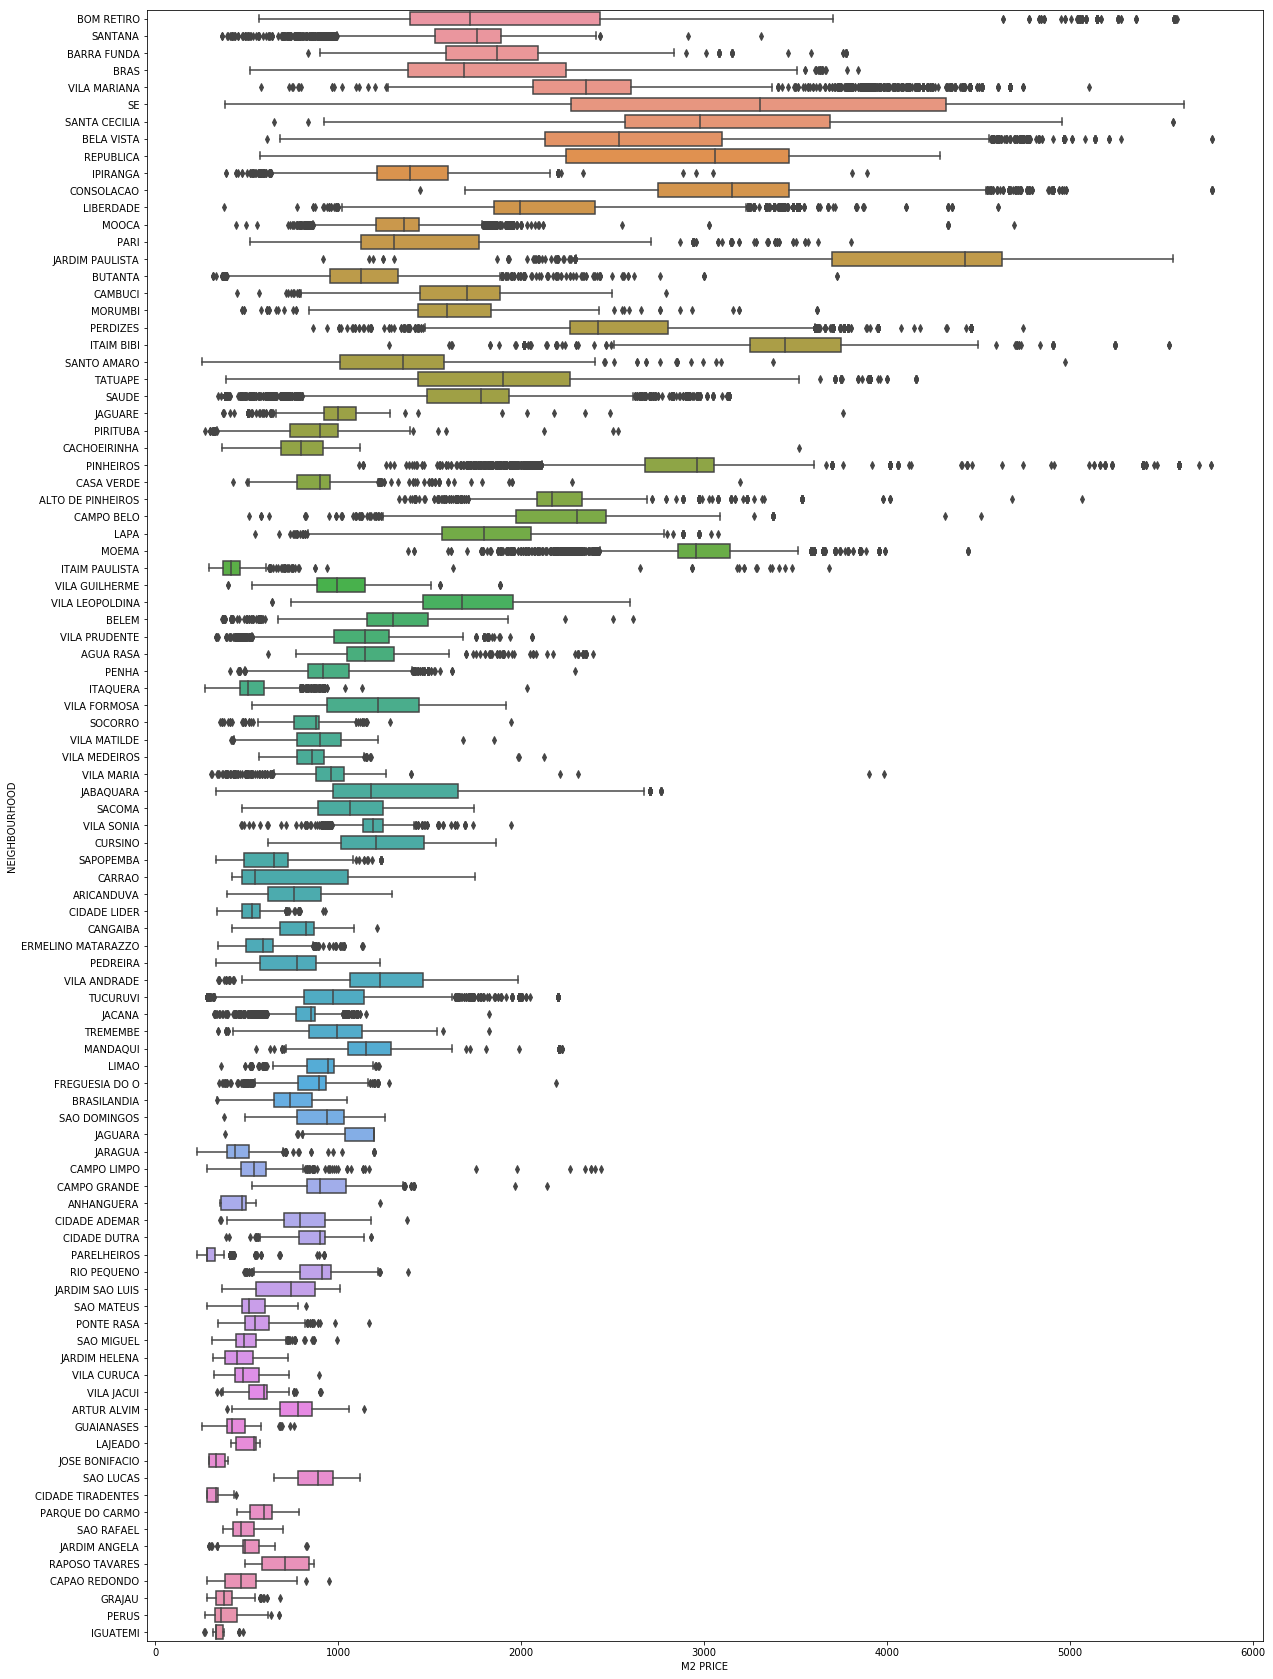

In [195]:
plt.figure(figsize=(20, 30))
sns.boxplot(x="M2 PRICE", y="NEIGHBOURHOOD", data=landvalueDF);

### Plot mean district prices in a Choroplet Map

Get mean value for each district and print the top 10 priciest districts:

In [196]:
meanLandvalueDF = landvalueDF.groupby(landvalueDF['NEIGHBOURHOOD'], as_index=False)['M2 PRICE'].mean()
meanLandvalueDF.sort_values('M2 PRICE', ascending=False).head(10)

,NEIGHBOURHOOD,M2 PRICE
43,JARDIM PAULISTA,4171.954443
33,ITAIM BIBI,3485.832970
78,SE,3358.342139
25,CONSOLACAO,3172.886841
68,SANTA CECILIA,3024.118106
51,MOEMA,2986.880359
65,REPUBLICA,2963.098361
61,PINHEIROS,2872.190450
6,BELA VISTA,2683.101501
59,PERDIZES,2543.700905


Plot Choroplet map with mean district prices.

In [218]:
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(meanLandvalueDF['M2 PRICE'].min(),
                              meanLandvalueDF['M2 PRICE'].max(),
                              10, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

map = folium.Map(location=[-23.549896, -46.631258], zoom_start=12)

folium.Choropleth(
    geo_data=geojson,
    data=meanLandvalueDF,
    columns=['NEIGHBOURHOOD', 'M2 PRICE'],
    key_on='feature.properties.nomecaps',
    threshold_scale=threshold_scale,
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Sao Paulo land value',
).add_to(map)

for lat, long, label in zip(zones['centroid_lat'], zones['centroid_lon'], zones['nome']):      
    folium.CircleMarker(
        [lat, long],
        radius = 3,
        fill = True,
        fill_opacity = 0.5,
        popup=label
    ).add_to(map)

folium.LayerControl().add_to(map)
map

### Check data distribution

Plot histograms to check data distribution for each column:

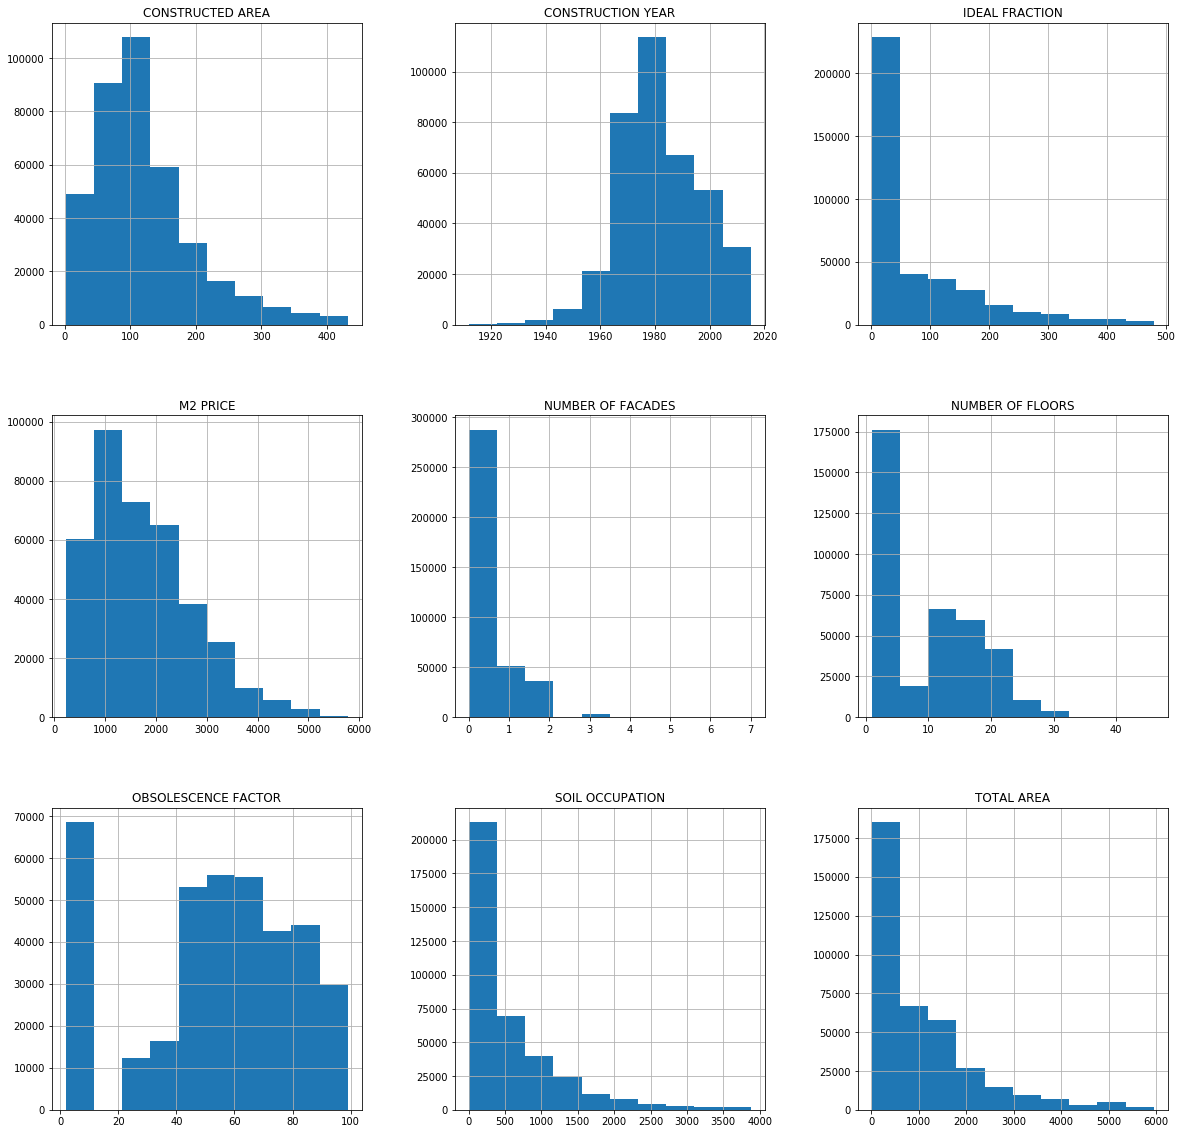

In [199]:
landvalueDF.hist(figsize=(20, 20));

### Plot a scatter matrix to search for correlations with the price value

Let's plot a scatter matrix to visualize any possible correlation with the M2 PRICE column:

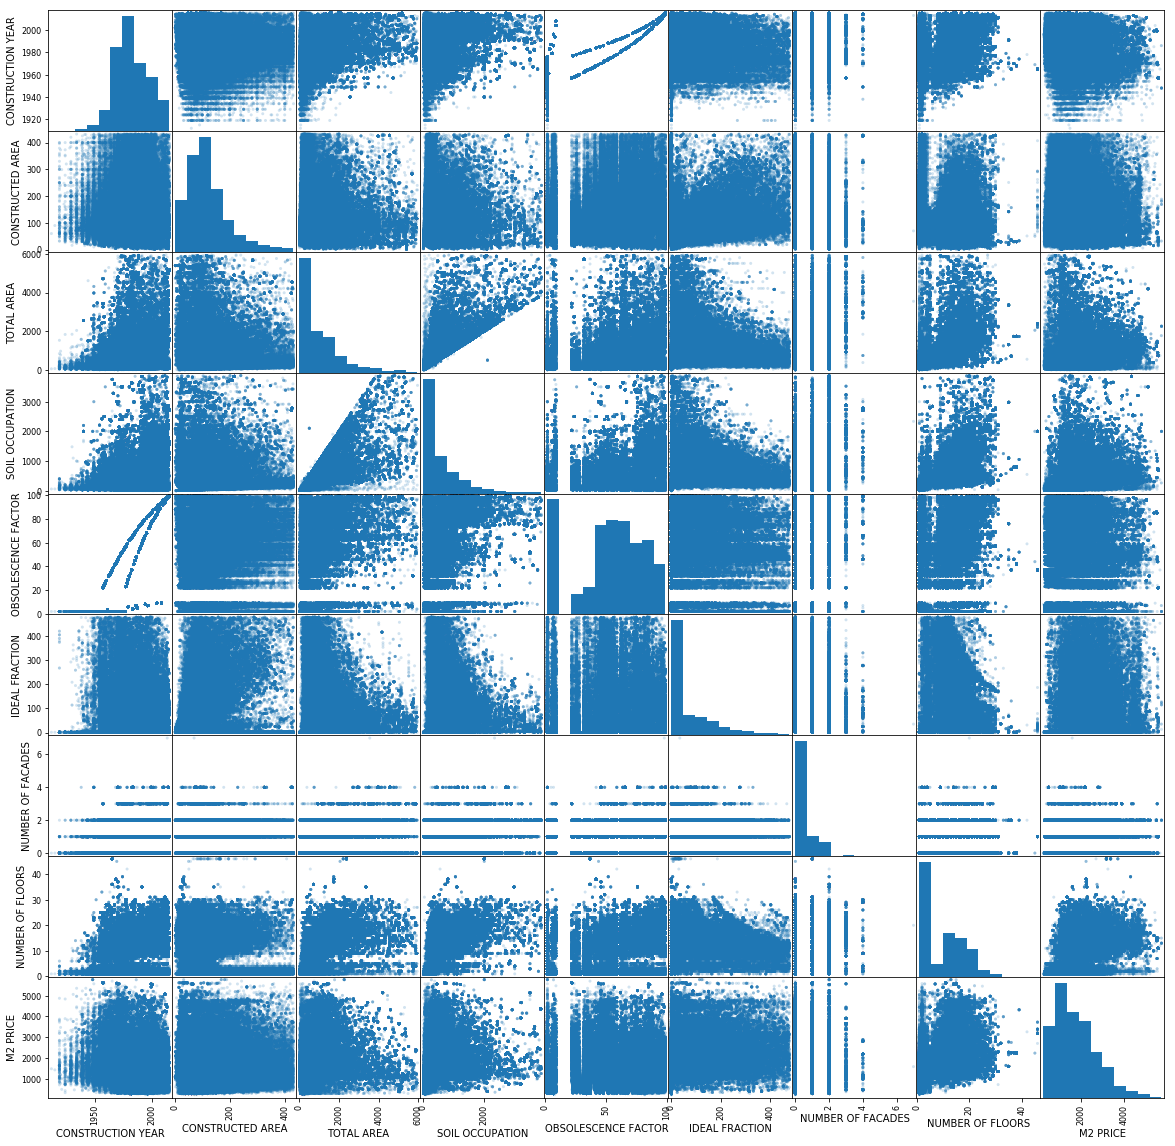

In [79]:
scatter_matrix(landvalueDF, alpha=0.2, figsize=(20, 20));

The scatter matrix did not reveal strong correlations with the price column. Seems like the best bet for a simple linear regression would be the NUMBER OF FLOORS.

### Label encode categorical features and plot a correlation heatmap

Let's try to label encode our categorical features and search for other correlations.

In [200]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

encoded_data, _ = number_encode_features(landvalueDF)
encoded_data.sample(10)

,CONSTRUCTION YEAR,CONSTRUCTED AREA,TOTAL AREA,SOIL OCCUPATION,NEIGHBOURHOOD,OBSOLESCENCE FACTOR,IDEAL FRACTION,NUMBER OF FACADES,NUMBER OF FLOORS,CONSTRUCTION TYPE,LAND POSITION,TYPE,M2 PRICE
592025,1970,220,232,80,52,46,1,0,3,3,4,19,1285.0
190065,1977,25,1315,528,14,57,33,2,16,23,0,14,2246.0
88501,1975,96,260,96,35,54,1,0,1,17,4,31,592.5
208340,1998,225,159,83,11,84,1,0,2,17,4,31,918.5
149478,1969,148,119,74,77,44,1,0,2,17,4,31,1617.5
735388,1962,99,1341,650,13,32,23,0,6,23,4,0,1706.5
27696,1983,92,150,92,35,66,1,0,1,17,4,31,570.0
161769,2011,110,1615,1124,77,96,169,0,15,23,4,0,1609.0
234004,1998,29,2672,1456,70,84,12,0,9,24,4,14,1602.5
203111,1970,31,452,400,6,46,134,0,8,23,4,0,3630.0


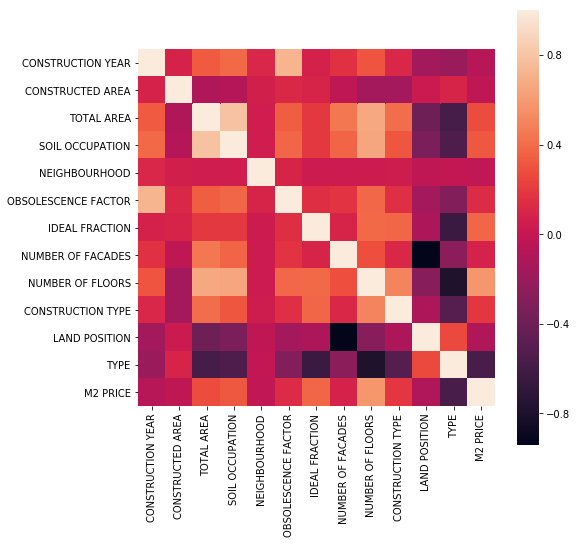

In [201]:
plt.figure(figsize=(8, 8));
sns.heatmap(encoded_data.corr(), square=True);
plt.show()

## Model Creation and Evaluation

### Simple Linear Regression 

Let's first try creating a simple linear regression model with feature NUMBER OF FLOORS and target M2 PRICE.

In [202]:
X = landvalueDF[['NUMBER OF FLOORS']]
y = landvalueDF[['M2 PRICE']]

Split the dataset and train the model.

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Predict prices and plot the results in a regression plot.

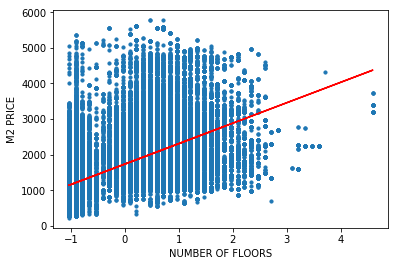

In [204]:
y_pred = model.predict(X_test)

plt.scatter(X_test, y_test, s=10)
plt.xlabel('NUMBER OF FLOORS')
plt.ylabel('M2 PRICE')

# predicted values
plt.plot(X_test, y_pred, color='r')
plt.show()

In [206]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

'MSE: %.2f, RMSE: %.2f, R2 SCORE: %.2f' % (mse, rmse, r2)

'MSE: 636040.94, RMSE: 797.52, R2 SCORE: 0.34'

### Multiple Linear Regression with One Hot Encoding

In [207]:
# Copy the original data
oneHotFeatures = landvalueDF.copy()

# Select the numeric columns
numeric_subset = oneHotFeatures.select_dtypes('number')
categorical_subset = oneHotFeatures.select_dtypes('object')

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
oneHotFeatures = pd.concat([numeric_subset, categorical_subset], axis = 1)
oneHotFeatures.head()

,CONSTRUCTION YEAR,CONSTRUCTED AREA,TOTAL AREA,SOIL OCCUPATION,OBSOLESCENCE FACTOR,IDEAL FRACTION,NUMBER OF FACADES,NUMBER OF FLOORS,M2 PRICE,NEIGHBOURHOOD_AGUA RASA,...,"TYPE_Outras edificações de uso especial, com utilização múltipla",TYPE_Posto de serviço,"TYPE_Prédio de apartamento, não em condomínio, de uso exclusivamente residencial","TYPE_Prédio de apartamento, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios), com ou sem loja (predominância residencial)","TYPE_Prédio de escritório ou consultório, não em condomínio, com ou sem lojas","TYPE_Prédio de escritório, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios) com ou sem loja (predominância comercial)",TYPE_Residência,"TYPE_Residência coletiva, exclusive cortiço (mais de uma residência no lote)",TYPE_Residência e outro uso (predominância residencial),TYPE_Templo
170,1924,100,116,92,2,1,0,1,1257.5,0,...,0,0,0,0,0,0,1,0,0,0
296,1970,280,148,140,46,1,2,2,1225.0,0,...,0,0,0,0,0,0,0,0,0,0
344,1970,300,200,150,46,1,0,2,1208.0,0,...,0,0,0,0,0,0,0,0,0,0
411,1961,175,300,155,3,13,0,7,1410.5,0,...,0,0,0,0,0,0,0,0,0,0
430,1957,55,622,551,22,133,1,9,1914.5,0,...,0,0,0,0,0,0,0,0,0,0


Split and scale the data:

In [208]:
oneHot_X = features[features.columns.drop("M2 PRICE")]
oneHot_y = features[["M2 PRICE"]]

oneHot_X_train, oneHot_X_test, oneHot_y_train, oneHot_y_test = train_test_split(oneHot_X, oneHot_y, test_size=0.25, random_state=42)

scaler = preprocessing.StandardScaler()
oneHot_X_train = pd.DataFrame(scaler.fit_transform(oneHot_X_train), columns=oneHot_X_train.columns)
oneHot_X_test = scaler.transform(oneHot_X_test)

Train the model and make predictions:

In [209]:
oneHot_model = LinearRegression()
oneHot_model.fit(oneHot_X_train, oneHot_y_train)

oneHot_y_pred = oneHot_model.predict(oneHot_X_test)

In [210]:
oneHot_mse = mean_squared_error(oneHot_y_test, oneHot_y_pred)
oneHot_rmse = np.sqrt(oneHot_mse)
oneHot_r2 = r2_score(oneHot_y_test, oneHot_y_pred)

'MSE: %.2f, RMSE: %.2f, R2 SCORE: %.2f' % (oneHot_mse, oneHot_rmse, oneHot_r2)

'MSE: 124135.81, RMSE: 352.33, R2 SCORE: 0.87'